Deep convolutional generative adversarial networks for Simpsons faces (https://www.kaggle.com/datasets/kostastokis/simpsons-faces)

About Dataset

Dataset contains Simpsons faces, extracted from seasons 25-28. 

Cropped images are as extracted directly from the video files. 
 
Simplified images were built as a by-product of the face recognition algorithm. They only present the eyes and skin of the recognized face.

All images are 200x200 pixels, each centered on a single face. 

In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2)
import random
from tensorflow.random import set_seed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/GIT_AI/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/GIT_AI


In [ ]:
# from zipfile import ZipFile

# with ZipFile('DATA/simpsons/simplified.zip', 'r') as zip_ref:
#     zip_ref.extractall('DATA/simpsons/')

In [ ]:
print(len(os.listdir('DATA/simpsons/simplified/')))

9877


In [ ]:
test = imread('DATA/simpsons/simplified/5000.png')

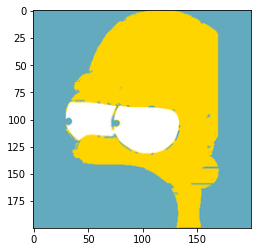

In [ ]:
plt.imshow(test)

## Reshape and Rescale Images for DCGAN

Generator is using `tanh` activation function for the last layer, so rescaling of `X_train` to be within -1 to 1 limits is needed. To faster calculation conversion to grayscale and image size = [48, 48] is applied. 

In [29]:
#image_gen = ImageDataGenerator()

In [9]:
image_gen = ImageDataGenerator(preprocessing_function=lambda x: (x-114)/141*2. - 1.) 

In [10]:
X_train = image_gen.flow_from_directory('DATA/simpsons/', target_size=(48, 48), color_mode='grayscale', batch_size=64)

Found 9877 images belonging to 1 classes.


In [31]:
# minimum = 255
# for i in range(0,155):
#   if X_train[i][0].min() < minimum:
#     minimum = X_train[i][0].min()
# minimum

114.0

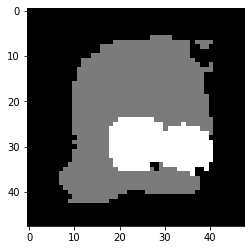

In [11]:
batch=next(X_train)
plt.imshow(batch[0][0][:, :, 0], cmap='gray')

In [12]:
batch[0][0][:, :, 0].min()

-0.4751773

In [13]:
batch[0][0][:, :, 0].max()

1.0

In [14]:
X_real = image_gen.flow_from_directory('DATA/simpsons/', target_size=(48, 48), color_mode='grayscale', batch_size=32)[0][0]

Found 9877 images belonging to 1 classes.


In [15]:
X_real.shape

(32, 48, 48, 1)

## Model training

In [39]:
def reset_random_seeds(seeds):
   os.environ['PYTHONHASHSEED']=str(2)
   set_seed(seeds)
   np.random.seed(2022)
   random.seed(2022)

In [40]:
reset_random_seeds(2022)

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, padding="same",
                        activation=LeakyReLU(0.2),
                        input_shape=[48, 48, 1]))
#discriminator.add(BatchNormalization(epsilon=5e-5))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same",
                        activation=LeakyReLU(0.2)))
#discriminator.add(BatchNormalization(epsilon=5e-5))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same",
                        activation=LeakyReLU(0.2)))
discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding="same",
                        activation=LeakyReLU(0.2)))
#discriminator.add(BatchNormalization(epsilon=5e-5))
discriminator.add(Flatten())
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation="sigmoid"))

In [41]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 1)                 9

In [42]:
generator = Sequential()
generator.add(Dense(6*6*256, input_shape=[100], activation=LeakyReLU(0.2)))
generator.add(Reshape([6, 6, 256]))
#generator.add(BatchNormalization(epsilon=5e-5))
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same",
                                 activation=LeakyReLU(0.2)))
#generator.add(BatchNormalization(epsilon=5e-5))
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same",
                                 activation=LeakyReLU(0.2)))
#generator.add(BatchNormalization(epsilon=5e-5))
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same",
                                 activation=LeakyReLU(0.2))) #activation="relu"
#generator.add(BatchNormalization(epsilon=5e-5))
generator.add(Conv2DTranspose(1, kernel_size=4, padding="same",
                                 activation="tanh"))

In [43]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 9216)              930816    
                                                                 
 reshape (Reshape)           (None, 6, 6, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 128)      524416    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 24, 24, 128)      262272    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 48, 48, 128)      262272    
 ranspose)                                                       
                                                      

In [44]:
generator_0 = generator

In [ ]:
# "weights-{epoch:03d}-{val_loss:.4f}.hdf5"
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_loss', 
#                                 verbose=0, save_best_only=True, mode='min' )
# checkpoint = tf.train.Checkpoint(model)
# checkpoint.restore(checkpoint_dir)


# loaded_model = keras.models.load_model('best_model')
# new_history = loaded_model.fit(train_dataset, epochs=20,
#                     validation_data=test_dataset,
#                     validation_steps=30,
#                     callbacks=[stop_early, checkpoint],
#                     )

In [45]:
GAN = Sequential([generator, discriminator])

### Setting up Training Batches

In [16]:
X_train[154][0].shape

(21, 48, 48, 1)

In [ ]:
epochs = 190
# Grab the seprate components
generator, discriminator = GAN.layers
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.trainable = False 
GAN.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

for epoch in range(epochs):
    print(f"Currently on Epoch {epoch + 1}")
    i = 0
    # For every batch in the dataset
    for b in range(len(X_train)-1): #drop last batch
        X_batch = X_train[b][0]
        i=i+1
        if i%20 == 0:
            GAN.save(f'GAN_batch_{i}.h5')
            print(f"\tCurrently on batch number {i} of {len(X_train)}")
            
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[64, 100])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]]*64 + [[1.]]*64)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        d, _ = discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[64, 100])
        
        # Make discriminator to belive that fake images are real
        y2 = tf.constant([[1.]]*64)
        
        # Avoid a warning
        discriminator.trainable = False
        
        g = GAN.train_on_batch(noise, y2)

    #loss
    print(f"\tDiscriminator loss {d}")
    print(f"\tGenerator loss {g}")
    #real images accuracy
    _, acc_real = discriminator.evaluate(X_real, tf.constant([[1.]]*32), verbose=0)
  	# prepare fake examples
    noise_test = tf.random.normal(shape=[32, 100])
  	# evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(generator(noise_test), tf.constant([[0.]]*32), verbose=0)
    print(f"Real images accuracy: {acc_real:.4f}")
    print(f"Fake images accuracy: {acc_fake:.4f}")    
GAN.save('GAN_7_190epochs.h5')        
print("TRAINING COMPLETE")            

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks/GIT_AI/
# from tensorflow.keras.models import load_model
# GAN.save('GAN_5_10epochs.h5')      
# # model = load_model('....h5')
# hist_json_file = 'simpleRNN_unempl_history.json' 
# with open(hist_json_file, mode='w') as f:
#      pd.DataFrame(model.history.history).to_json(f)

# import joblib
# joblib.dump(full_scaler,'RNNscaler_unempl.pkl')

In [33]:
# GAN = load_model('GAN_7_190epochs.h5')
# generator, discriminator = GAN.layers

In [27]:
noise = tf.random.normal(shape=[5, 100]) #generate 5 images

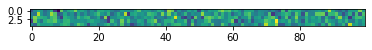

In [ ]:
plt.imshow(noise)

**Before training**

In [ ]:
img_before = generator_0(noise)

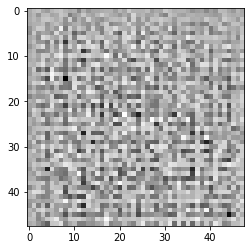

In [ ]:
plt.imshow(img_before[0].numpy().reshape(48, 48), cmap='Greys')
plt.show()

**After training**

In [34]:
images = generator(noise)

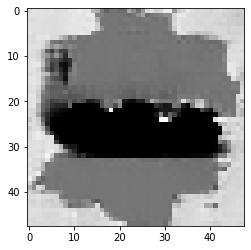

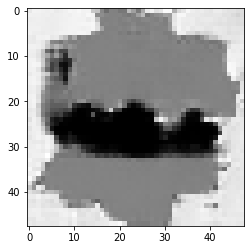

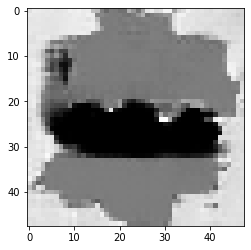

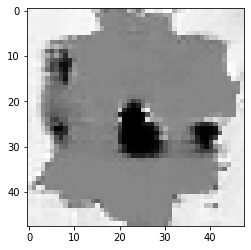

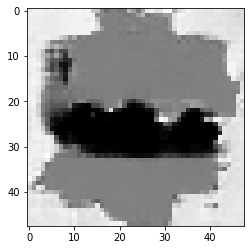

In [35]:
#after 190 epochs
for image in images:
    plt.imshow(image.numpy().reshape(48, 48), cmap='Greys')
    plt.show()